In [80]:
import snap
import json
import collections
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import numpy as np
import random
import os

In [76]:
# nx.readwrite.json_graph.node_link_data(G)
from networkx.readwrite import json_graph

In [67]:
business_path = '../yelp/yelp_academic_dataset_business.json'
user_path = '../yelp/yelp_academic_dataset_user.json'
review_path = '../yelp/yelp_academic_dataset_review.json'
tip_path = '../yelp/yelp_academic_dataset_tip.json'
review_small_path = '../yelp/review_small.json'
user_small_path = '../yelp/user_small.json'
business_small_path = '../yelp/business_small.json'
tip_small_path = '../yelp/tip_small.json'

In [3]:
def find_reviews(path, path2):
    print 'begin parsing reviews and tips...'
    business_reviews = collections.defaultdict(list) # bid: [(uid, date)]
    reviews = {} # review_id: (b_id, u_id, date)
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
            reviews[raw['review_id']] = (raw['business_id'], raw['user_id'], raw['date'])
            business_reviews[raw['business_id']].append((raw['user_id'], raw['date']))
            
    # path2: tip
    with open(path2) as json_file:
        for line in json_file:
            raw = json.loads(line)
            business_reviews[raw['business_id']].append((raw['user_id'], raw['date']))
    print 'done.'
    return business_reviews, reviews

In [4]:
def find_friends(path):
    print 'begin parsing users...'
    user_friends = collections.defaultdict(list) # {uid : [friends]}
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
            if raw['friends'] != 'None':
                user_friends[raw['user_id']] = raw['friends'].split(', ')
    print 'done.'
    return user_friends

In [5]:
def find_elites(path):
    print 'begin parsing users...'
#     user_friends = collections.defaultdict(list) # {uid : [friends]}
    elite_class = {}
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
#             if raw['friends'] != 'None':
#                 user_friends[raw['user_id']] = raw['friends'].split(', ')
            if raw['elite'] != 'None':
                elite_years = raw['elite'].split(', ')
                if len(elite_years) > 0:
                    elite_class[raw['user_id']] = True
                else:
                    elite_class[raw['user_id']] = False
    print 'done.'
    return elite_class  

In [6]:
def gather_business_cascades(path, business_reviews, user_friends):
    cascading_length = collections.defaultdict(list) # {city : [graph diameter]}
    longest = collections.defaultdict(int) # city : longerst diameter
    graph = {} # city : graph
    print 'begin gathering cascades...'
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
            city = raw['city']
            bid = raw['business_id']
            G, ecc, center = construct_local_graph(business_reviews[bid], user_friends)
            cascading_length[city].append(ecc)
            if ecc > longest[city]:
                longest[city] = ecc
                graph[city] = (G, center)
    print 'done.'
    return cascading_length, longest, graph
            

In [99]:
def gather_business_cascades_size(path, business_reviews, user_friends):
    cascading_length = collections.defaultdict(list) # {city : [graph diameter]}
#     longest = collections.defaultdict(int) # city : longerst diameter
    graph = {} # city : graph
    print 'begin gathering cascades...'
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
            city = raw['city']
            bid = raw['business_id']
            G, size = construct_local_graph(business_reviews[bid], user_friends)
            cascading_length[city].append(size)
#             if ecc > longest[city]:
#                 longest[city] = ecc
#                 graph[city] = (G, center)
    print 'done.'
    return cascading_length

In [94]:
def nx_gather_business_cascades(path, business_reviews, user_friends, elite_class, feats):
    test = 0
    print 'begin generating graphs...'
    business_ids = []
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
            city = raw['city']
            bid = raw['business_id']
            G, nid2int, class_map, user_feats = nx_construct_local_graph(
                business_reviews[bid], user_friends, elite_class, feats)
            if len(list(G.node)) < 15:
                continue
            
            test += 1
            data1 = json_graph.node_link_data(G)
            with open('GraphSAGE_input/' + bid + '-id_map.json', 'w') as fmap:
                json.dump(nid2int, fmap)
            with open('GraphSAGE_input/' + bid + '-G.json', 'w') as fg:
                json.dump(data1, fg)
            with open('GraphSAGE_input/' + bid + '-class_map.json', 'w') as fg:
                json.dump(class_map, fg)
                
            np.save('GraphSAGE_input/' + bid + '-feats', user_feats)
            os.system('python GraphSAGE/graphsage/utils.py GraphSAGE_input/%s-G.json GraphSAGE_input/%s-walks.txt'%(bid, bid))
            business_ids.append(bid + '\n')
#             if test > 3:
#                 break
    with open('GraphSAGE_input/bid.txt', 'w') as f:
        for i in business_ids:
            f.write(i)        
    print 'done.'

In [95]:
def nx_construct_local_graph(business_review, user_friends, elite_class, feats):
    G = nx.Graph()

    cleaned = {} # uid : time
    nid2int = {}
    class_map = {}
    G = nx.Graph()
    for uid, date in business_review:
        if len(user_friends[uid]) > 0:
            cleaned[uid] = date
#             uid2node[uid] =  G.AddNode(-1)
    for uid in cleaned:
        for friend in user_friends[uid]:
            if friend in cleaned and cleaned[friend] > cleaned[uid]:
                u_label = [1] if uid in elite_class else [0]
                f_label = [1] if friend in elite_class else[0]
                G.add_node(uid, label=u_label, feature=list(feats[uid]))
                G.add_node(friend, label=f_label, feature=list(feats[friend]))
                G.add_edge(uid, friend)
                class_map[uid] = u_label[0]
                class_map[friend] = f_label[0]
    mapped_int = 0
    user_feats = []
    for idx, nid in enumerate(list(G.node)):
        if idx >= len(list(G.node)) * 0.85:
            G.node[nid]['test'] = True
            G.node[nid]['val'] = False
        elif idx >= len(list(G.node)) * 0.7:
            G.node[nid]['val'] = True
            G.node[nid]['test'] = False
        else:
            G.node[nid]['test'] = False
            G.node[nid]['val'] = False            
        nid2int[nid] = mapped_int
        mapped_int += 1
        user_feats.append(feats[nid])
    return G, nid2int, class_map, user_feats

In [96]:
nx_gather_business_cascades(business_path, business_reviews, user_friends, elite_class, user_feats)

begin generating graphs...
done.


In [98]:
def construct_local_graph(business_review, user_friends):
    cleaned = {} # uid : time
    uid2node = {}
    G = snap.TNGraph.New()
    for uid, date in business_review:
        if len(user_friends[uid]) > 0:
            cleaned[uid] = date
#             uid2node[uid] =  G.AddNode(-1)
    for uid in cleaned:
        for friend in user_friends[uid]:
            if friend in cleaned and cleaned[friend] > cleaned[uid]:
                if uid not in uid2node:
                    uid2node[uid] = G.AddNode(-1)
                if friend not in uid2node:
                    uid2node[friend] = G.AddNode(-1)
                G.AddEdge(uid2node[uid], uid2node[friend])
#     center = G.AddNode(-1)
#     for nid in G.Nodes():
#         if nid.GetInDeg() == 0 and nid.GetId() != center:
#             G.AddEdge(center, nid.GetId())
#     ecc = snap.GetNodeEcc(G, center, True)
    return G, G.GetNodes()

In [49]:
# import pickle
# user_friends = find_friends(user_small_path)
# business_reviews, reviews = find_reviews(review_small_path, tip_small_path)
# elite_class = find_elites(user_small_path)
# with open('business_reviews.pkl', 'wb') as f:
#     pickle.dump(business_reviews, f)""
# with open('user_friends.pkl', 'wb') as f:
#     pickle.dump(user_friends, f)
# with open('elite_class.pkl', 'wb') as f:
#     pickle.dump(elite_class, f)

begin parsing users...
done.
begin parsing reviews and tips...
done.
begin parsing users...
done.


In [31]:
G = nx.Graph()
u_label = [1] if 5 > 3 else [0]
print u_label

G.add_node(0, val=False, label=[1], test=False)
G.node[0]['test'] = True
print (0 in G.node)
G.add_node(1)
G.add_node(1234567895555555555555)
print G.node
G.add_edge(0, 1)
from networkx.readwrite import json_graph
data1 = json_graph.node_link_data(G)
s1 = json.dumps(data1)
print s1

G_data = json.load(open('GraphSAGE_input/0jtRI7hVMpQHpUVtUy4ITw-G.json'))
print G_data
ttest =  nx.readwrite.json_graph.node_link_graph(G_data)


# dic = {1:2, 3:4}
# with open('json_test.json', 'w') as ft:
#     json.dump(dic, ft)
# print s2

[1]
True
{0: {'test': True, 'val': False, 'label': [1]}, 1: {}, 1234567895555555555555L: {}}
{"directed": false, "graph": {}, "nodes": [{"test": true, "id": 0, "val": false, "label": [1]}, {"id": 1}, {"id": 1234567895555555555555}], "links": [{"source": 0, "target": 1}], "multigraph": false}
{u'directed': True, u'graph': {}, u'nodes': [{u'test': False, u'id': u'77lef7kKkoOVupY-7AmieQ', u'val': False, u'label': [1]}, {u'test': False, u'id': u'Yg08tRMxm0eaL-rXyNIAHw', u'val': False, u'label': [1]}, {u'test': False, u'id': u'VZRxANvyTm2ixS6jYDGgEw', u'val': False, u'label': [1]}, {u'test': False, u'id': u'A8TRpa--43-mbig73xfhrA', u'val': False, u'label': [1]}, {u'test': False, u'id': u'pkq41Qh9yGOI_4pwdVmmDg', u'val': False, u'label': [1]}, {u'test': False, u'id': u'4Cv7E77vkZ6S4JRDl-lMkA', u'val': False, u'label': [0]}, {u'test': False, u'id': u'leyNDNVu09Ldbg5ujPWMhQ', u'val': False, u'label': [1]}, {u'test': False, u'id': u'uEvusDwoSymbJJ0auR3muQ', u'val': False, u'label': [1]}, {u'tes

In [119]:
def plot_cascading_length_dist(cascadings):
    def getbins(arr):
        n, bins, patches = plt.hist(arr)
        plt.close()
        return n, bins
    
#     dic = collections.defaultdict(int)
    for city in cascadings:
        tmp = cascadings[city]
        if len(tmp) < 1000:
            continue
        dic = collections.defaultdict(int)
        for i in tmp:
            dic[i] += 1
        xs = []
        ys = []
        for k in dic:
            xs.append(k)
            ys.append(dic[k])

        plt.figure()
        plt.plot(xs, ys, '.')
        plt.yscale('log')
        plt.xscale('log')
        plt.title(city)
        plt.grid()
#         plt.ylim(bottom=1)
        plt.savefig('cascades_size_dist/size-' + city + '.png')


#         tmp = cascadings[city]
#         for i in tmp:
#             dic[i] += 1
#     xs = []
#     ys = []
#     for k in dic:
#         xs.append(k)
#         ys.append(dic[k])
#     plt.figure()
#     plt.plot(xs, ys, '.')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.savefig('cascades_size_dist/overall.png', ppi=1000)

In [117]:
# sizes = gather_business_cascades_size(business_path, business_reviews, user_friends)

/home/yilong/hw2-bundle/env/local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


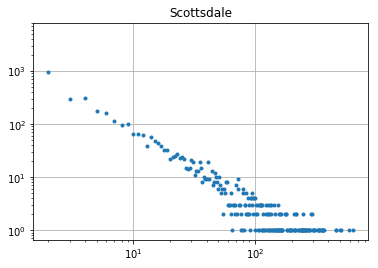

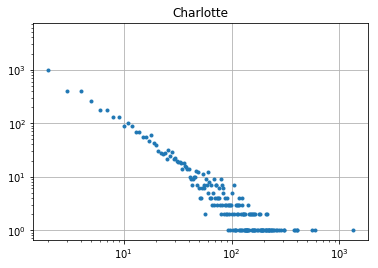

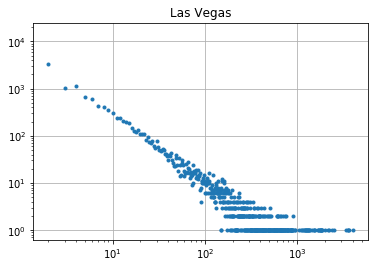

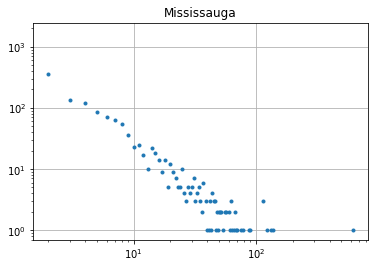

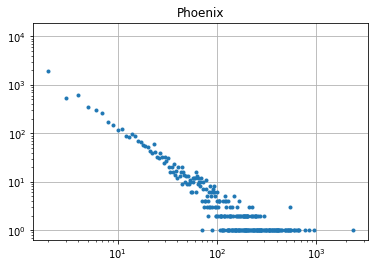

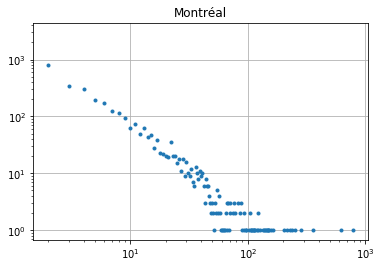

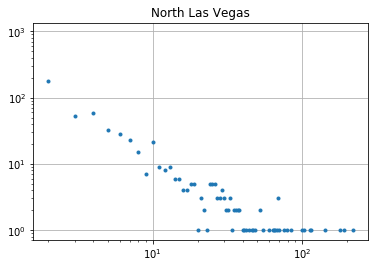

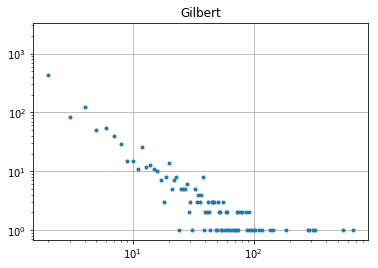

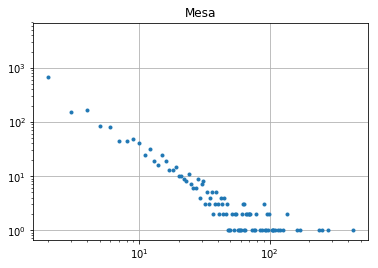

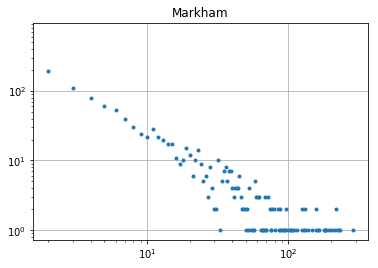

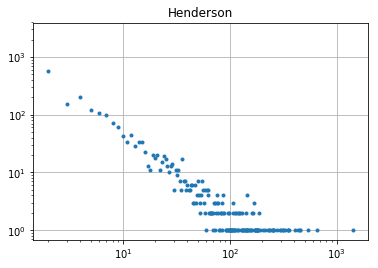

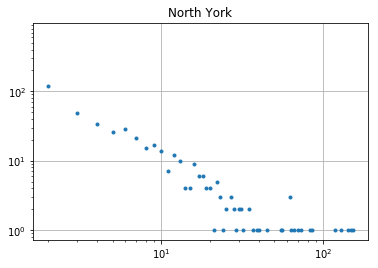

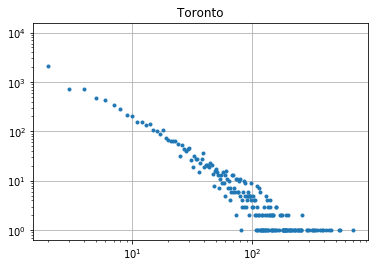

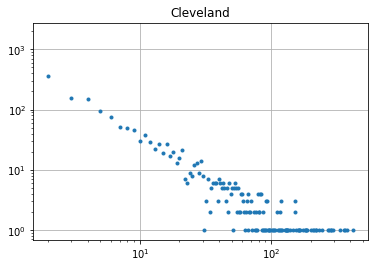

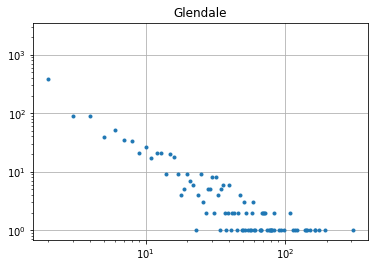

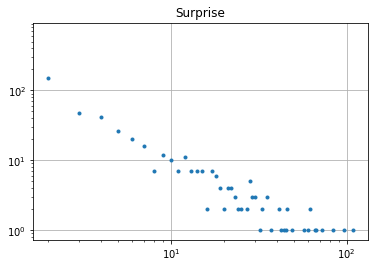

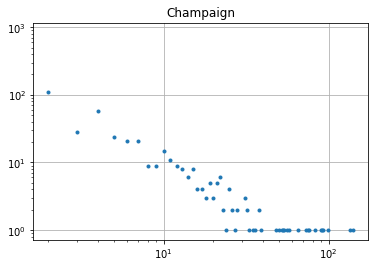

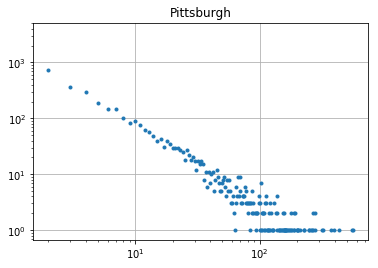

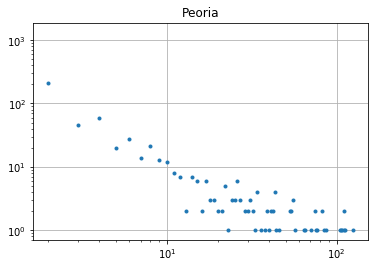

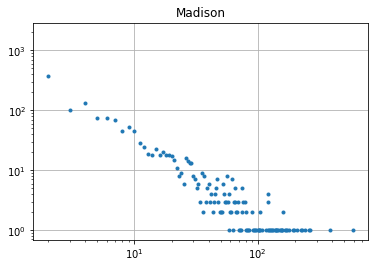

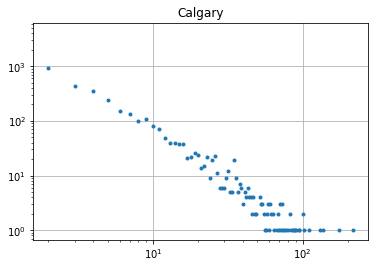

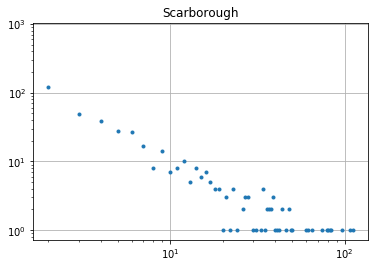

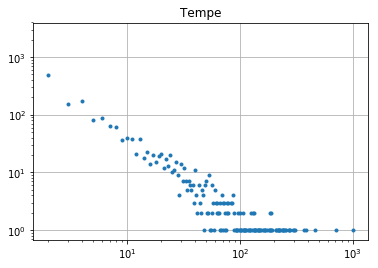

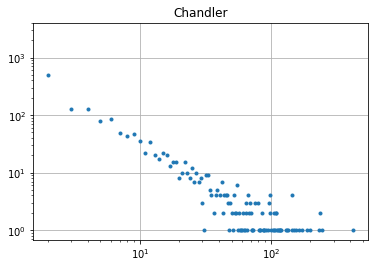

In [120]:
plot_cascading_length_dist(sizes)

In [10]:
def whatisthis(s):
    if isinstance(s, str):
        print "ordinary string"
    elif isinstance(s, unicode):
        print "unicode string"
    else:
        print "not a string"
def plot_cascade_graph(graph, cascading_len):
    for city in graph:
        if len(cascading_len[city]) < 500:
            continue

#         a = 'Montréal'.decode("utf-8")
#         print city == a
#         whatisthis(city)
#         name = city.replace(u'\xe9', 'e')
#         print name
        g, center = graph[city]
        NIdColorH = snap.TIntStrH()
        for node in g.Nodes():
            idx = node.GetId()
            if idx != center:
                NIdColorH[idx] = 'green'
            else:
                NIdColorH[idx] = 'red'

        name = city.replace(u'\xe9', 'e')
        name = name.replace(' ', '_')
        snap.DrawGViz(g, snap.gvlDot, 'cascades_graph/cascade-' + name + '.png', name, False, NIdColorH)

In [65]:
business_reviews = business_reviews = collections.defaultdict(list)
user_friends = collections.defaultdict(list) # {uid : [friends]}
with open('business_reviews.pkl', 'rb') as f:
    business_reviews = pickle.load(f)
with open('user_friends.pkl', 'rb') as f:
    user_friends = pickle.load(f)
with open('elite_class.pkl', 'rb') as f:
    elite_class = pickle.load(f)

In [190]:
cascading_length, longest, graph = gather_business_cascades(business_path, business_reviews, user_friends) 

begin gathering cascades...
done.


In [254]:
plot_cascade_graph(graph, cascading_length)

Scottsdale [0.  0.7 1.4 2.1 2.8 3.5 4.2 4.9 5.6 6.3] [5.317e+03 0.000e+00 1.784e+03 0.000e+00 9.790e+02 5.440e+02 0.000e+00
 1.780e+02 1.700e+01 3.000e+00]
Richmond Hill [0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8 5.4] [466.   0.   0. 254.   0. 167.  74.   0.  15.   2.]
Charlotte [0.  0.7 1.4 2.1 2.8 3.5 4.2 4.9 5.6 6.3] [4.957e+03 0.000e+00 1.982e+03 0.000e+00 1.398e+03 7.000e+02 0.000e+00
 1.470e+02 1.900e+01 1.000e+00]
Las Vegas [0.  0.9 1.8 2.7 3.6 4.5 5.4 6.3 7.2 8.1] [1.5489e+04 0.0000e+00 6.6650e+03 3.6700e+03 2.1440e+03 7.3900e+02
 1.4300e+02 1.3000e+01 1.0000e+00 1.0000e+00]
Lakewood [0.  0.7 1.4 2.1 2.8 3.5 4.2 4.9 5.6 6.3] [224.   0. 123.   0. 102.  48.   0.   9.   2.   1.]
Mississauga [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5] [1714.    0.    0.    0.  687.    0.  386.    0.  151.   16.]
Phoenix [0.  0.7 1.4 2.1 2.8 3.5 4.2 4.9 5.6 6.3] [1.2123e+04 0.0000e+00 3.5710e+03 0.0000e+00 1.7100e+03 8.5900e+02
 0.0000e+00 3.2600e+02 3.9000e+01 5.0000e+00]
Montréal [0.  0.6 1.2 1.8 2.4 3.  

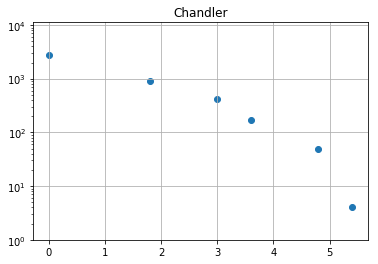

In [195]:
plot_cascading_length_dist(cascading_length)

In [220]:
a = 'Saint-J\xe9r\xf4me'
print 'abcd'.replace('\xe9', 'e')
print a

abcd
Saint-J�r�me


In [3]:
import pickle
with open('user-feats.pkl') as f:
    user_feats = pickle.load(f)

In [32]:
# a = random.choice(user_feats.keys())
a = user_feats.keys()
# print np.array(user_feats[a])
user_num = len(a)
print a[1]
dim = len(user_feats[a[1]])

mO3Bz9dD7BK0Y50hlpY-Pg


In [33]:
tmp = np.zeros((user_num, dim))

In [34]:
for i in range(user_num):
    tmp[i] = np.array(user_feats[a[i]])

In [43]:
import sklearn
from sklearn.preprocessing import normalize

In [48]:
user_feats[a[0]]
tmp_norm = tmp -  np.mean(tmp, axis = 0)

In [55]:
tmp_normalized = normalize(tmp_norm, norm='l2')

In [57]:
for i in range(user_num):
    k = a[i]
    user_feats[k] = tmp_normalized[i]

In [60]:
# with open('user_feats_norm.pkl', 'wb') as f:
#     pickle.dump(user_feats, f)